# 1. Install and Import Dependencies

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 887.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not curre

In [ ]:
!pip install transformers requests beautifulsoup4 pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

plt.style.use('ggplot')

# 2. Instantiate Model

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

bert_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# 3. Encode and Calculate Sentiment

In [ ]:
tokens = bert_tokenizer.encode('It was good but couldve been better. Great', return_tensors='pt')

In [ ]:
result = bert_model(tokens)

In [ ]:
result.logits

tensor([[-2.7768, -1.2353,  1.4419,  1.9804,  0.4584]],
       grad_fn=<AddmmBackward>)

In [ ]:
result

SequenceClassifierOutput(loss=None, logits=tensor([[-2.7768, -1.2353,  1.4419,  1.9804,  0.4584]],
       grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [ ]:
int(torch.argmax(result.logits))+1

4

# 4. Collect Reviews

In [ ]:
r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [ ]:
reviews

["Great coffee and vibe. That's all \xa0you need. Crab was outstanding but not good finger food like a taco should be. Really want to try the pork belly sandwich - looked excellent. This became my go to breakfast place in Darling harbor. Had the avocado salmon salad breakfast and it was excellent. Service has been excellent.",
 "Great coffee and vibe. That's all \xa0you need. Crab was outstanding but not good finger food like a taco should be. Really want to try the pork belly sandwich - looked excellent.",
 'Great food amazing coffee and tea. Short walk from the harbor. Staff was very friendly',
 'Great staff and food. \xa0Must try is the pan fried Gnocchi! \xa0The staff were really friendly and the coffee was good as well',
 "Ricotta hot cakes! These were so yummy. I ate them pretty fast and didn't share with anyone because they were that good ;). I ordered a green smoothie to balance it all out. Smoothie was a nice way to end my brekkie at this restaurant. Others with me ordered the

# 5. Load Reviews into DataFrame and Score

In [ ]:
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [ ]:
df['review'].iloc[0]

"Great coffee and vibe. That's all \xa0you need. Crab was outstanding but not good finger food like a taco should be. Really want to try the pork belly sandwich - looked excellent. This became my go to breakfast place in Darling harbor. Had the avocado salmon salad breakfast and it was excellent. Service has been excellent."

In [ ]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
sentiment_score(df['review'].iloc[1])

4

In [ ]:
df['bert'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [ ]:
df

,review,bert
0,Great coffee and vibe. That's all you need. C...,5
1,Great coffee and vibe. That's all you need. C...,4
2,Great food amazing coffee and tea. Short walk ...,5
3,Great staff and food. Must try is the pan fri...,5
4,Ricotta hot cakes! These were so yummy. I ate ...,5
5,I came to Social brew cafe for brunch while ex...,5
6,We came for brunch twice in our week-long visi...,4
7,It was ok. The coffee wasn't the best but it w...,3
8,I went here a little while ago- a beautiful mo...,2
9,This place is a gem. The ambiance is to die fo...,3


In [ ]:
df['review'].iloc[3]

'Great staff and food. \xa0Must try is the pan fried Gnocchi! \xa0The staff were really friendly and the coffee was good as well'

## RoBERTa

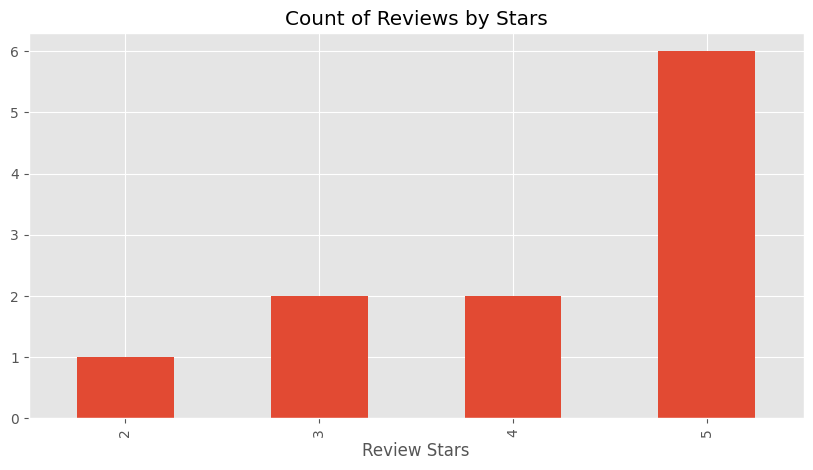

In [ ]:
ax = df['bert'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
example = df['review'][10]
print(example)
print(df.shape)

Ron & Jo are on the go down under and Wow!  We've found our breakfast place in Sydney and are coming back before we leave!   I yelped you the Social Brew Cafe which was a few blocks from where we are staying so off we went.  They have seating outside and inside and it was a little chilly and they had a table available inside so we grabbed it.  The menu has a lot of tantalizing choices and our very nice waitress made some suggestions that we took.  Jo went with the ricotta pancakes with iced tea and I ordered the smoked salmon with a macchiato.  Our drinks were served quickly and my wife's crimson iced tea had a nice flavor and macchiato was served dark and rich.  Jo's pancakes came with a liberal number of fresh strawberries and the ricotta was spread between the first and second pancake with a pistachio butter (lots of ground pistachios) in between the second and third cake.  These pancakes were well presented and so delicious!  Jo order a side of bacon which was a crispy generous Can

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer.encode('It was good but couldve been better. Great', return_tensors='pt')
output = model(encoded_text)
print(output)
print(torch.argmax(output.logits)+1)


SequenceClassifierOutput(loss=None, logits=tensor([[-1.8582, -0.3348,  2.7281]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)
tensor(3)


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer.encode(example, return_tensors='pt')
    output = model(encoded_text)
    return int(torch.argmax(output.logits))+1

In [ ]:
df['roberta'] = df['review'].apply(lambda x: polarity_scores_roberta(x[:512]))

# res = {}
# it=0
# for i, row in tqdm(df.iterrows(), total=len(df)):
#     try:
#         text = row['review']
#         roberta_result = polarity_scores_roberta(text)
#         both = {roberta_result}
#         res[it] = both
#         it+=1
#     except RuntimeError:
#         print(f'Broke for id {it}')

In [ ]:
df

,review,bert,roberta
0,Great coffee and vibe. That's all you need. C...,5,3
1,Great coffee and vibe. That's all you need. C...,4,3
2,Great food amazing coffee and tea. Short walk ...,5,3
3,Great staff and food. Must try is the pan fri...,5,3
4,Ricotta hot cakes! These were so yummy. I ate ...,5,3
5,I came to Social brew cafe for brunch while ex...,5,3
6,We came for brunch twice in our week-long visi...,4,3
7,It was ok. The coffee wasn't the best but it w...,3,3
8,I went here a little while ago- a beautiful mo...,2,2
9,This place is a gem. The ambiance is to die fo...,3,3


# Working on different dataset

In [ ]:
# Read in data
df = pd.read_csv("small_data.csv")
print(df.shape)
df = df.head(5000)
print(df.shape)

(34660, 21)
(5000, 21)


<ipython-input-7-efd67095e24a>:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("small_data.csv")


In [ ]:
data = df[['reviews.rating', 'reviews.text']]
data

,reviews.rating,reviews.text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...
...,...,...
4995,4.0,Amazing tablet for the price i love it is real...
4996,5.0,I love my fire... The games and the pictures g...
4997,1.0,Great tablet for kids but the screen isn't as ...
4998,4.0,Great product easy to use. Having different co...


In [ ]:
data.shape

(5000, 2)

In [ ]:
data.isnull().sum()

reviews.rating    23
reviews.text       1
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data.head(5)

,reviews.rating,reviews.text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [ ]:
# renaming columns
data.rename(columns = {'index':'id','reviews.rating':'rating', 'reviews.text':'text'}, inplace = True)
data.head(5)

<ipython-input-13-afb7b89db2ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns = {'index':'id','reviews.rating':'rating', 'reviews.text':'text'}, inplace = True)


,rating,text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


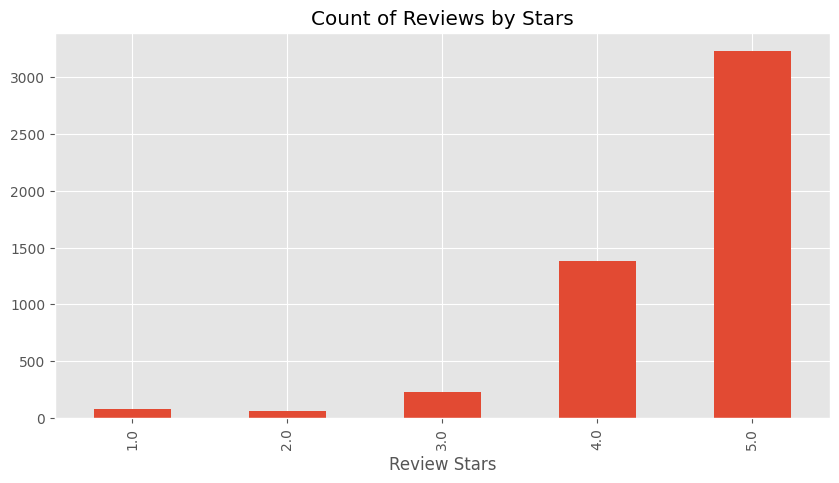

In [ ]:
ax = data['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

### Bert

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

bert_model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
# calculate sentiment scores
def sentiment_score_bert(review):
    tokens = bert_tokenizer.encode(review, return_tensors='pt')
    result = bert_model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
tqdm.pandas(desc='bert model')  
data['bert_rating']=data['text'].progress_apply(lambda x: sentiment_score_bert(x[:512]))  
data.tail(10)

bert model:   0%|          | 0/4976 [00:00<?, ?it/s]

<ipython-input-17-b7ff94b13d4e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bert_rating']=data['text'].progress_apply(lambda x: sentiment_score_bert(x[:512]))


,rating,text,bert_rating
4990,5.0,Right size for travel. Perfect for reading. Ev...,5
4991,3.0,The tablet is great for reading and watching m...,5
4992,5.0,The tablet has been great for reading and the ...,4
4993,4.0,This product is great for children. Easy to us...,5
4994,4.0,The fact that it has parental control so I can...,5
4995,4.0,Amazing tablet for the price i love it is real...,5
4996,5.0,I love my fire... The games and the pictures g...,5
4997,1.0,Great tablet for kids but the screen isn't as ...,3
4998,4.0,Great product easy to use. Having different co...,5
4999,5.0,"Love this tablet, great price and is really fa...",5


### RoBERTa

In [ ]:
R_MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
roberta_tokenizer = AutoTokenizer.from_pretrained(R_MODEL)
roberta_model = AutoModelForSequenceClassification.from_pretrained(R_MODEL)

In [ ]:
def sentiment_score_roberta(example):
    encoded_text = roberta_tokenizer.encode(example, return_tensors='pt')
    output = roberta_model(encoded_text)
    return int(torch.argmax(output.logits))+1

In [ ]:
tqdm.pandas(desc='roberta model')  
data['roberta_rating']=data['text'].progress_apply(lambda x: sentiment_score_roberta(x[:512]))  
data.tail(10)

roberta model:   0%|          | 0/4976 [00:00<?, ?it/s]

<ipython-input-23-420ef253330b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['roberta_rating']=data['text'].progress_apply(lambda x: sentiment_score_roberta(x[:512]))


,rating,text,bert_rating,roberta_rating
4990,5.0,Right size for travel. Perfect for reading. Ev...,5,3
4991,3.0,The tablet is great for reading and watching m...,5,3
4992,5.0,The tablet has been great for reading and the ...,4,3
4993,4.0,This product is great for children. Easy to us...,5,3
4994,4.0,The fact that it has parental control so I can...,5,3
4995,4.0,Amazing tablet for the price i love it is real...,5,3
4996,5.0,I love my fire... The games and the pictures g...,5,3
4997,1.0,Great tablet for kids but the screen isn't as ...,3,1
4998,4.0,Great product easy to use. Having different co...,5,3
4999,5.0,"Love this tablet, great price and is really fa...",5,3


## Cmparing both models on the basis of rating

### it compares which  model has less no of differences than that of others

In [ ]:
def compare(a : int,b : int) -> bool:
  return a==b

In [ ]:
print(type(data['rating'][0]))
print(type(data['bert_rating'][0]))

<class 'numpy.float64'>
<class 'numpy.int64'>


In [ ]:
bert_res = np.where(data['rating']==data['bert_rating'], True, False)
unique, counts = np.unique(bert_res, return_counts=True)
dict(zip(unique, counts))

{False: 1770, True: 3206}

In [ ]:
roberta_res = np.where(data['rating']==data['roberta_rating'], True, False)
unique, counts = np.unique(roberta_res, return_counts=True)
dict(zip(unique, counts))

{False: 4804, True: 172}